In [1]:
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
from numpy.random import poisson as poi
import time
import genSIRUniverse as gsu
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

from numpy import poly1d, polyfit
import pandas as pd
import time
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn.decomposition import NMF, PCA
from sklearn.manifold import LocallyLinearEmbedding, TSNE, Isomap, SpectralEmbedding, MDS
from pydiffmap import diffusion_map as dm

%matplotlib inline
%load_ext autoreload
%autoreload 2

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [2]:
#Some global definitions
state_loc = {"S":0, "I":1, "R":2}

# Test single simulation instances.
- Here you can test simulation times for different universe sizes, universe connectivities, infection/recovery parameters.
- There are a few visualization routines to inspect how each simulation progresses: ```show_state_vs_time``` and ```show_snapshots```.  

## This setup below shows damped oscillations for a ring-connected population whose recovered fraction gradually becomes susceptible again. 
- Each node is connected to 4 neighbors (in addition to itself): [-2,-1, +1, +2].
- We used a small $\alpha$ (i.e. rate for recovered->susceptible) to create infection oscillations. 
- Notice that as ```avg_pop_per_node``` is reduced, infections can spontaneously disappear when they are sufficiently low. 
- Because recovered population slowly become susceptible again, there will be multiple waves of infections. For instance, the second wave will occur when substantial fraction of the recovered population in originally infected site becomes susceptible again.
- Also notice that the fall in the number of infected persons is the largest after the first wave. 

In [112]:
universe_sh=(8,8)
conn = gsu.gen_ring_connection(*universe_sh, deg_vec=[1])
su0 = gsu.sir_universe(universe_sh=universe_sh, conn=conn, alpha=0.01, beta=0.8, gamma=0.2, avg_pop_per_node=10000)
su0.initialize()
su0.iterate(100, verbose=True)

100 iterations took 0.042s


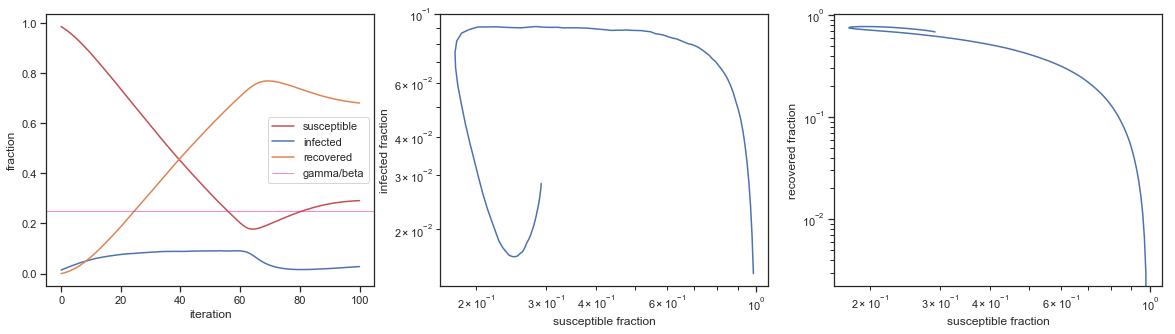

In [113]:
su0.show_state_vs_time()

### See how the infection propagates through the ring-topology. 
- When the number of infections become low, the signature of the initial infection wave is lost. 

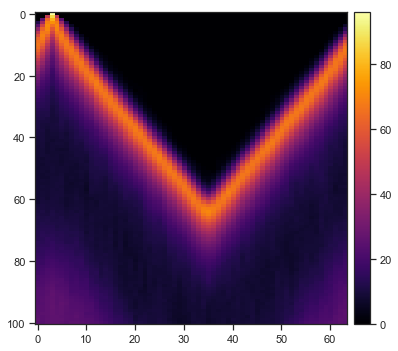

In [114]:
gsu.my_single_imshow(su0.np_state[:, su0.state_dict["I"],:]**0.5)

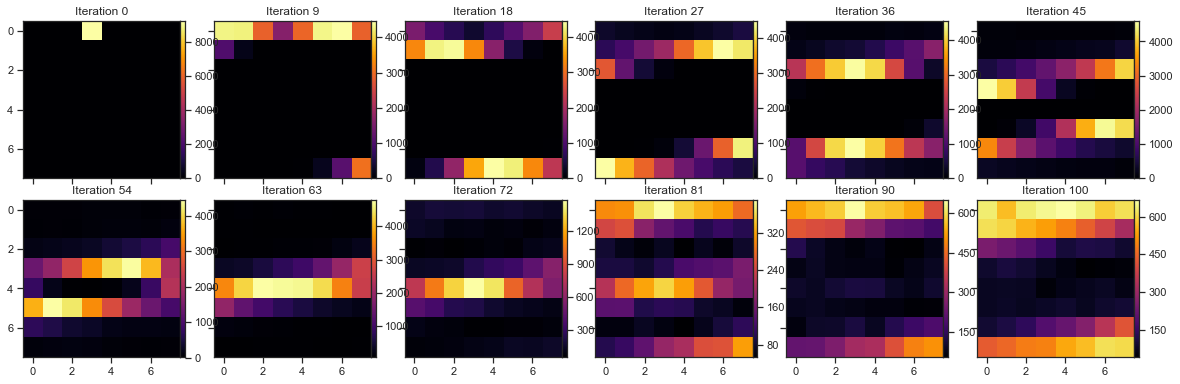

In [115]:
su0.show_snapshots(figsize=(20,10), nrows_ncols=(2,6))

### Here we estimate the doubling time and $R_0$ for early phases of infection. 
The data seems to support an exponential fit better than a power law fit. For fitting $R_0$, we adopt a simple phenomenological model:
$$\Delta I_t = \left(R_0 -1\right) \gamma I_t \;\Delta t \;. $$
For infinitesimal time steps $\Delta t \to 0$, gives
$$I_t = I_0 \exp{\left( \gamma(R_0 - 1) \right)} = I_0 \exp{t/t_e} \;.$$ 

Max $R_0$: 4.000


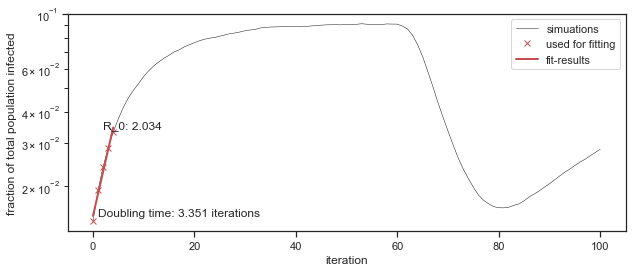

In [120]:
(doubling_time, r0) = su0.compute_r0(fit_t_range=[0,5])
print("Max $R_0$: {:0.3f}".format(su0.beta/su0.gamma))

## This bit of code to automate over different connectivity degrees for a ring-topology. 
- Possible that $R_0$ increases with node degree within the ring. But the trials below doesn't support it.

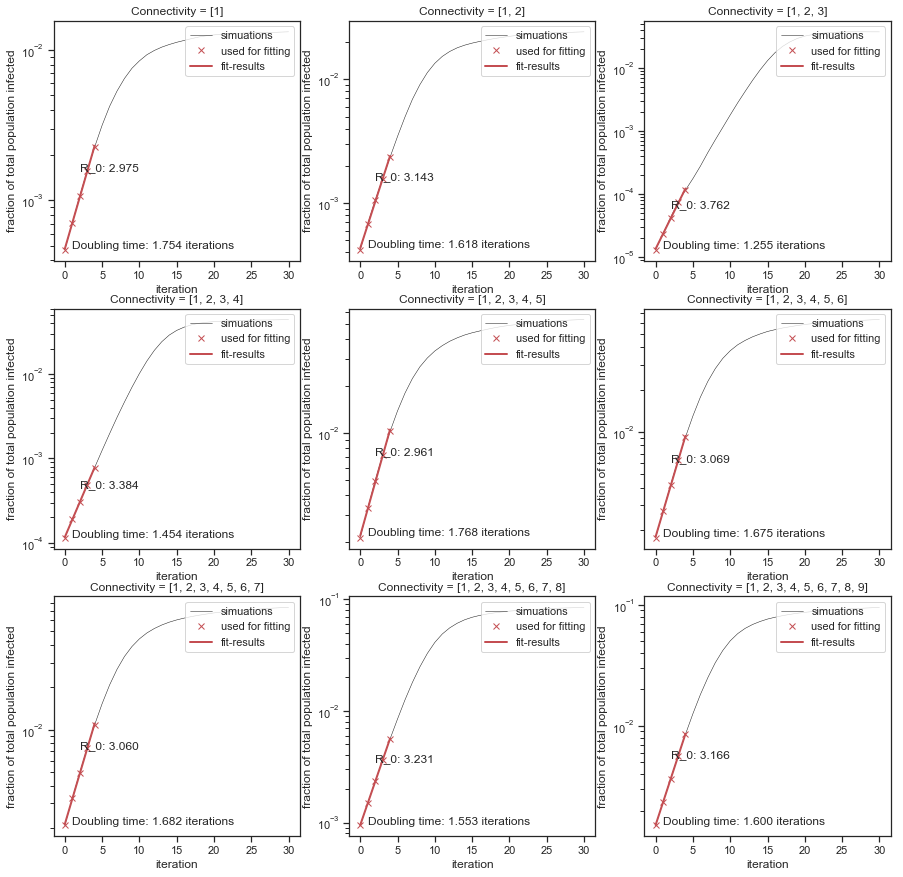

In [129]:
universe_sh=(20,20)
fig, axes = plt.subplots(3,3,figsize=(15,15))
deg_range = list(range(2,axes.size+2))
for ax,conn_deg in zip(axes.ravel(), deg_range):
    succeeded = False
    while not succeeded:
        try:
            curr_conn_deg = list(range(1,conn_deg))
            conn = gsu.gen_ring_connection(*universe_sh, deg_vec=curr_conn_deg)
            su0 = gsu.sir_universe(universe_sh=universe_sh, conn=conn, alpha=0.01, beta=0.8, gamma=0.2, avg_pop_per_node=10000)
            su0.initialize()
            su0.iterate(30)
            (doubling_time, r0) = su0.compute_r0(fit_t_range=[0,5], ax=ax, plot=True)
            ax.set_title("Connectivity = "+str(curr_conn_deg))
        except:
            pass
        succeeded = True


-----
## Let's try Moore connectivity (non-periodic boundary), and also increase the size of the universe.
- Notice that when the average population per node increases, the system retains a "ghost" of earlier infection pattern at later times when the recovered start to become susceptible again. 
- Does this 'ghost' eventually dies out when the total number of infections fall below a certain total number?

In [130]:
universe_sh=(10,10)
conn = gsu.gen_moore(*universe_sh, periodic=False)
su1 = gsu.sir_universe(universe_sh=universe_sh, conn=conn, alpha=0.01, beta=0.8, gamma=0.2, avg_pop_per_node=10000)
su1.initialize()
su1.iterate(200, verbose=True)

200 iterations took 0.082s


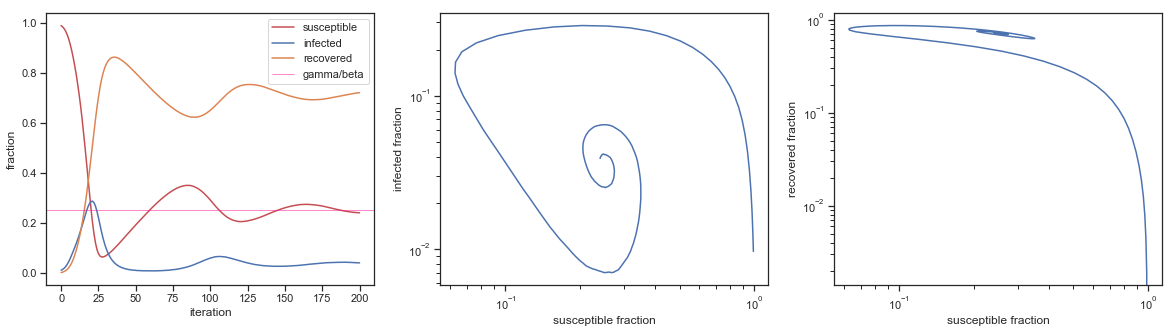

In [131]:
su1.show_state_vs_time()

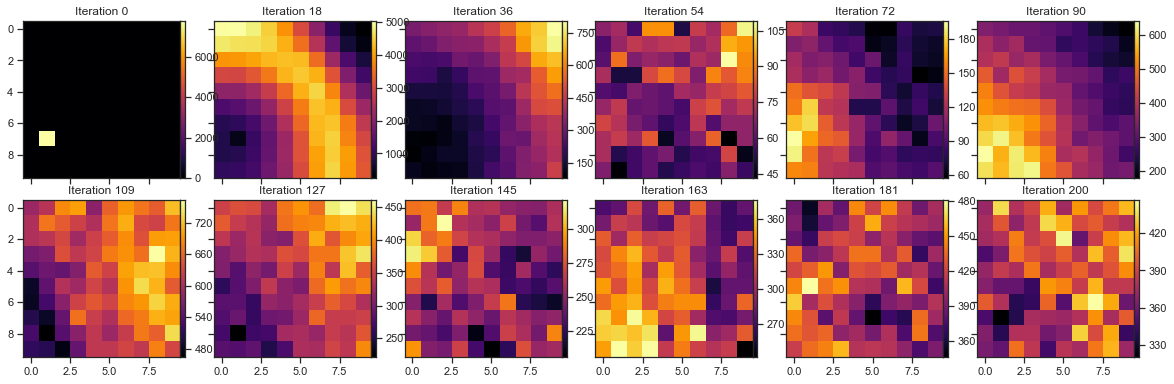

In [7]:
su1.show_snapshots(figsize=(20,10), nrows_ncols=(2,6))

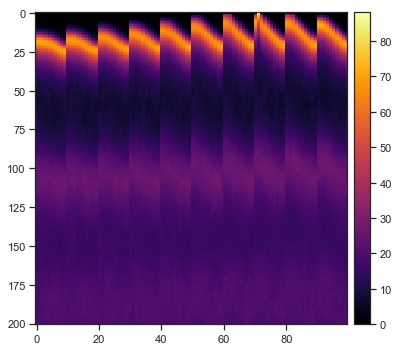

In [9]:
#Here I exponentiate the values to enhance the visualization of dimmer values.
gsu.my_single_imshow(su1.np_state[:, su1.state_dict["I"],:]**0.5)

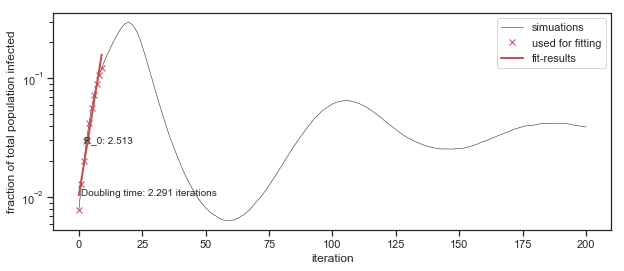

In [10]:
(doubling_time, r0) = su1.compute_r0(fit_t_range=[0,10])

## Here we try three different ways to compute the similarities between nodes. 
Basically, we can compute the similarities between two nodes ($i,j$) with the following pair-wise operations between their temporal infection patterns $I_i(t)$ and $I_j(t)$.
1. Their dot product: $I_i(t)\cdot I_j(t)$.
2. Their covariance.
3. Their pearson correlation.

#### Let's see if we can somehow infer the fact that underlying network here is Moore-connected with non-periodic boundary conditions.
- **Here we only look at how an infection cascades through a particular epidemic. **
- The idea is that we should be able to infer something about the underlying network just by looking at how the infection spreads through the universe.
- The pearson correlation and covariance approaches seem to produce the 'cleanest' signature of the connectivity. 
- We only take $I_i(t_1 \leq t \leq t_2)$ for a particular time window, when there are sufficiently many infections to infer correlations in the network.   

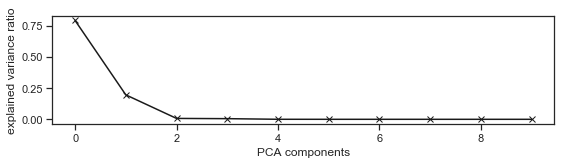

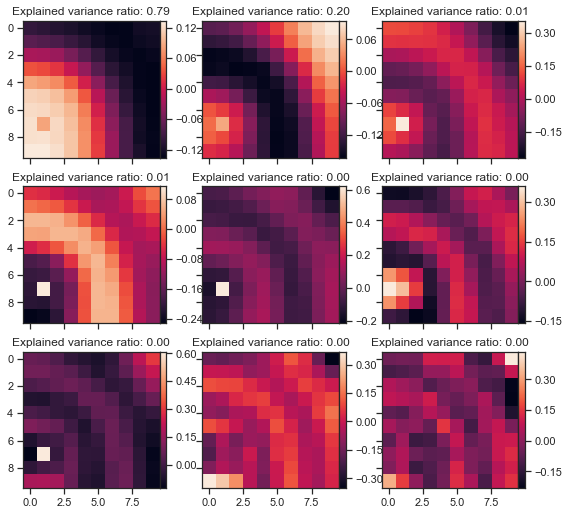

In [14]:
input_arr = su1.np_state[:50,state_loc["I"]].T

#This is simple matrix multiply
#pair_dot = np.matmul(input_arr.T, input_arr)

#This below is Pearson
#pair_dot = np.asarray([np.corrcoef(a, b)[1,0] for a in input_arr for b in input_arr]).reshape(len(input_arr), -1)

#This below is covariance. 
#But by sending this covariance to PCA, we essentially do another covariance on this covariance.
pair_dot = np.cov(input_arr)
pca_model, pca_transformed_input = gsu.pca_and_view(pair_dot, num_components=10, plot=False)

gsu.view_pca_2(pca_model, universe_sh, show_shape=(3,3), punit=3)

## Let's see what the PCA manifold looks like.
I haven't really interpreted these manifolds extensively but I suspect it is related to the simulation time.

In [15]:
time_of_first_infection = [ii.argmax() for ii in input_arr]

/Users/duaneloh/anaconda3/envs/idp/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/duaneloh/anaconda3/envs/idp/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


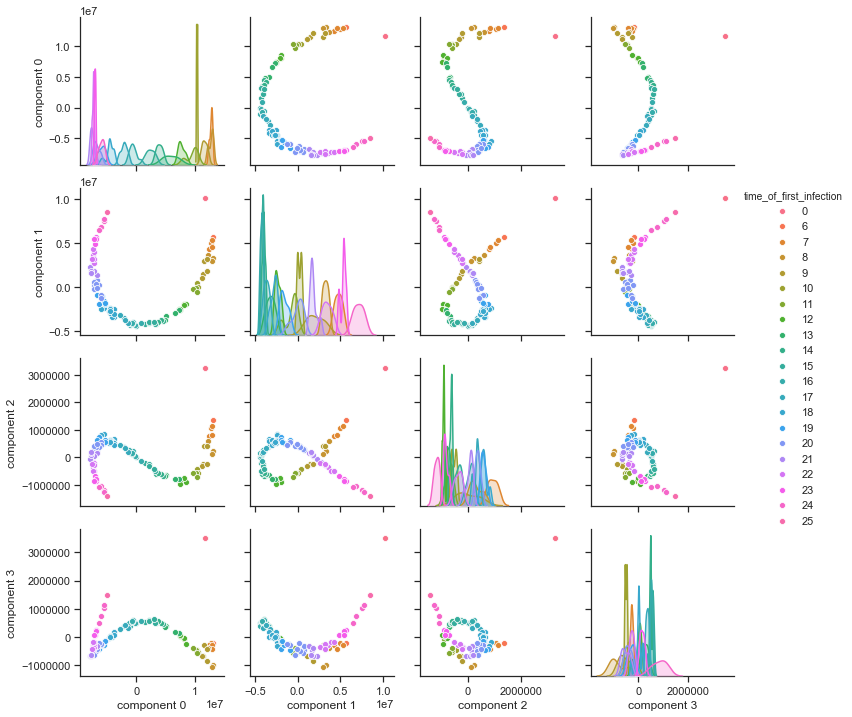

In [16]:
num_comp_to_show = 4
df = pd.DataFrame(pca_transformed_input)
df.columns = ["component {:d}".format(i) for i in range(len(pca_transformed_input.T))]
df['time_of_first_infection'] = time_of_first_infection
g = sns.pairplot(df, vars=["component {:d}".format(d) for d in range(num_comp_to_show)], 
                 hue='time_of_first_infection')